# Transform to local coordinates

# Purpose
Ship model coordinates are given in world fix coordinates: x0,y0,psi. 
Velocities will be transformed:

$$
    \begin{bmatrix} 
    \frac{dX}{dt} \\ 
    \frac{dX}{dt} \\
    r \\
    \end{bmatrix}   
    ->
    \begin{bmatrix} 
    u \\ 
    v \\
    r \\
    \end{bmatrix}       
$$

# Methodology
Transform with rotation of $\psi$

# Setup

In [1]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp
import seaborn as sns

## Local packages:
from src.data import mdl




Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [38]:
id=22773
df, units, meta_data = mdl.load(id=id)

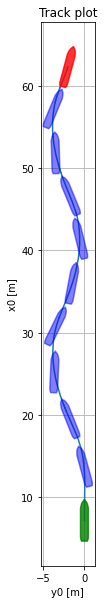

In [39]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

In [137]:
t = df.index.total_seconds()
df['x01d_gradient'] = np.gradient(df['x0'], t)
df['y01d_gradient'] = np.gradient(df['y0'], t)
df['z01d_gradient'] = np.gradient(df['z0'], t)
df['z02d_gradient'] = np.gradient(df['z01d_gradient'], t)

df['psi1d_gradient'] = np.gradient(df['psi'], t)

In [117]:
from pykalman import KalmanFilter

def filter(df, key='x0', observation_covariance = 100000):
    
    df = df.copy()
    
    dt = t[1] - t[0]
    
    A = np.array([[1, dt, 0.5*(dt**2)],
                  [0,  1, dt         ],
                  [0,  0, 1          ],
                    ])
    
    kf = KalmanFilter(transition_matrices=A,
                      initial_state_mean = [df[key].iloc[0:100].median(),df[f'{key}1d_gradient'].iloc[0:100].median(),0],
                      random_state=np.random.RandomState(0),
                      transition_covariance=100 * np.eye(3),
                      observation_covariance=observation_covariance * np.eye(1),
    
                      em_vars=[
                          'transition_covariance', 
                          'observation_covariance', 
                          'initial_state_mean', 
                      #    'initial_state_covariance'
                          ],
    
                      )
    
    observations = df[key]
    states_pred = kf.em(observations).smooth(observations)[0]
    
    df[f'{key}_filtered'] = states_pred[:,0]
    df[f'{key}1d'] = states_pred[:,1]
    df[f'{key}2d'] = states_pred[:,2]
    
    return df

In [124]:
df = filter(df=df, key='x0', observation_covariance = 1000000)
df = filter(df=df, key='y0', observation_covariance = 100000)
df = filter(df=df, key='psi', observation_covariance = 100000)

<AxesSubplot:xlabel='time'>

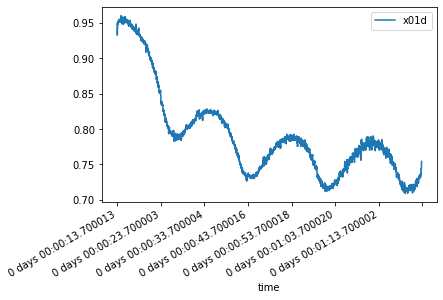

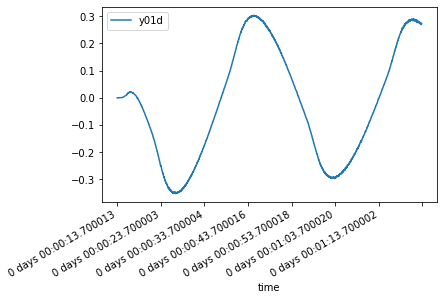

In [125]:
df.plot(y='x01d')
df.plot(y='y01d')

In [126]:
from scipy.spatial.transform import Rotation as R

In [127]:
rotation = R.from_euler('z', df['psi_filtered'], degrees=False)

In [138]:
df[['u','v','w']] = rotation.inv().apply(df[['x01d','y01d','z01d_gradient']])
df[['u1d','v1d','w1d']] = rotation.inv().apply(df[['x02d','y02d','z02d_gradient']])

df['r'] = df['psi1d']
df['r1d'] = df['psi2d']
df['beta'] = -np.arctan2(df['v'],df['u'])


<AxesSubplot:xlabel='time'>

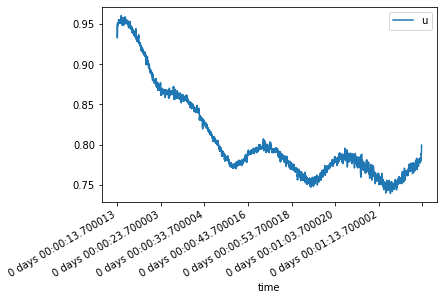

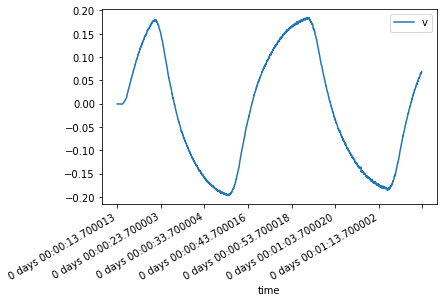

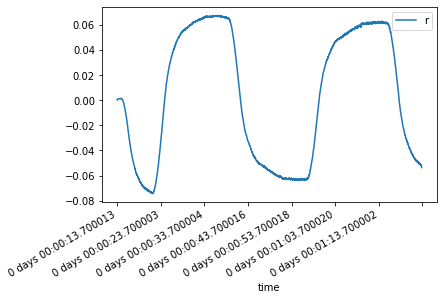

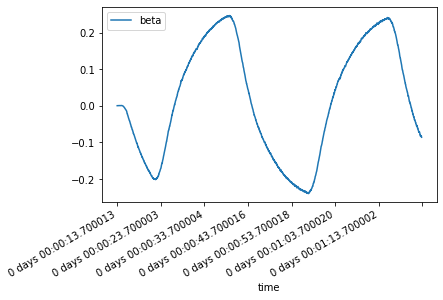

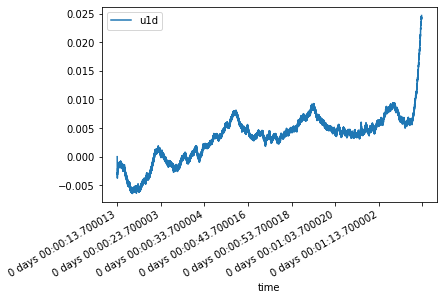

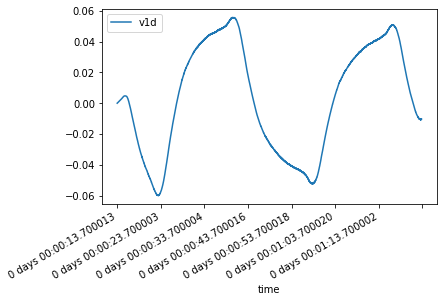

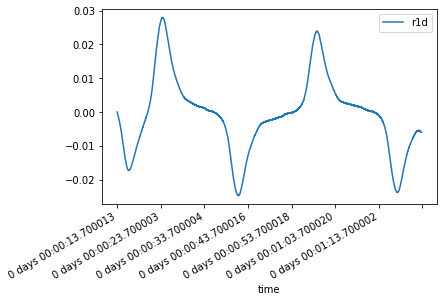

In [139]:
df.plot(y='u')
df.plot(y='v')
df.plot(y='r')
df.plot(y='beta')

df.plot(y='u1d')
df.plot(y='v1d')
df.plot(y='r1d')
